In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pybedtools as bt

In [2]:
species_dict = {
    'Ctenocephalides_felis': 'GCA_003426905.1_ASM342690v1_genomic',
    'Limnephilus_lunatus': 'GCA_917563855.1_iiLimLuna2.1_genomic',
    'Scyliorhinus_canicula': 'GCA_902713615.2_sScyCan1.2_genomic',
    'Octopus_sinensis': 'GCF_006345805.1_ASM634580v1_genomic'
}
te_bed_names=['chrom', 'start', 'end', 
              'tename', 'swscore', 'strand', 
              'pdiv', 'pdel', 'pins', 
              'sleft', 'tetype', 'qstart', 'qend', 'qleft', 'repeat_id']
zf_bed_names=['zchrom', 'zstart', 'zend']

In [3]:
def extract_te_info(filename):
    return pd.read_csv(filename, sep='\t', names=['tename', 'teclass', 'tefam'])

def te_bed_to_df(species, bedfile):
    bed_df = bedfile.to_dataframe(names=te_bed_names)
    bed_df['tename'] = bed_df['tename'].apply(lambda x: x.split('.')[0])
    try:
        te_info_df = extract_te_info(f'../data/dfam-libs/{species}_dfam_library_info.txt')
        bed_df = bed_df.merge(te_info_df, on='tename')
    except:
        bed_df['tefam'] = bed_df['tetype'].apply(lambda x: x.split('/')[-1])
        bed_df['teclass'] = bed_df['tetype'].apply(lambda x: x.split('/')[0])
    grouped_bed = bed_df.groupby('teclass')    
    teclass_dfs = {teclass: grouped_bed.get_group(teclass) for teclass in ['DNA', 'LTR', 'LINE', 'SINE', 'Unknown']}
    teclass_dfs['all'] = bed_df
    return teclass_dfs

In [4]:
coverage_df = []
for species, accession in species_dict.items():
    te_bed = bt.BedTool(f'../data/repeatmasker-out/{species}/{accession}.fna.bed')
    zf_bed = bt.BedTool(f'../data/beds/{species}_znfs.bed')
    genomefile = f'../data/genomes/{accession}.genome'
    
    teclass_dfs = te_bed_to_df(species, te_bed)
    for teclass in ['all', 'LTR', 'DNA', 'LINE', 'SINE']:
        te_bed = bt.BedTool.from_dataframe(teclass_dfs[teclass])
        
        merged_slopped_zf_bed = zf_bed \
            .slop(g=genomefile,
                  b=1e5) \
            .merge()
        merged_slopped_shuffled_zf_bed = merged_slopped_zf_bed \
            .shuffle(g=genomefile)
    
        obs_df = merged_slopped_zf_bed.coverage(b=te_bed).to_dataframe()
        exp_df = merged_slopped_shuffled_zf_bed.coverage(b=te_bed).to_dataframe()
        obs_df['species'] = species
        exp_df['species'] = species
        obs_df['group'] = 'observed'
        exp_df['group'] = 'shuffled'
        obs_df['teclass'] = teclass
        exp_df['teclass'] = teclass
    
        coverage_df.append(obs_df)
        coverage_df.append(exp_df)

coverage_df = pd.concat(coverage_df).rename({'thickStart': 'coverage'}, axis=1)

In [5]:
age_df = []

for species, accession in species_dict.items():
    te_bed = bt.BedTool(f'../data/repeatmasker-out/{species}/{accession}.fna.bed')
    zf_bed = bt.BedTool(f'../data/beds/{species}_znfs.bed')
    genomefile = f'../data/genomes/{accession}.genome'
    
    merged_slopped_zf_bed = zf_bed \
        .slop(g=genomefile,
              b=1e5) \
        .merge()
    merged_slopped_shuffled_zf_bed = merged_slopped_zf_bed \
        .shuffle(g=genomefile)
    
    obs_df = merged_slopped_zf_bed.intersect(b=te_bed, wb=True).to_dataframe(names=zf_bed_names+te_bed_names)
    exp_df = merged_slopped_shuffled_zf_bed.intersect(b=te_bed, wb=True).to_dataframe(names=zf_bed_names+te_bed_names)
    obs_df['species'] = species
    exp_df['species'] = species
    obs_df['group'] = 'observed'
    exp_df['group'] = 'shuffled'

    obs_df['tename'] = obs_df['tename'].apply(lambda x: x.split('.')[0])
    exp_df['tename'] = obs_df['tename'].apply(lambda x: x.split('.')[0])

    try:
        del te_info_df
        te_info_df = extract_te_info(f'../data/dfam-libs/{species}_dfam_library_info.txt')
        obs_df = obs_df.merge(te_info_df, on='tename')
        exp_df = exp_df.merge(te_info_df, on='tename')
    except:
        obs_df['tefam'] = obs_df['tetype'].apply(lambda x: x.split('/')[-1])
        obs_df['teclass'] = obs_df['tetype'].apply(lambda x: x.split('/')[0])
        exp_df['tefam'] = exp_df['tetype'].apply(lambda x: x.split('/')[-1])
        exp_df['teclass'] = exp_df['tetype'].apply(lambda x: x.split('/')[0])
        
    age_df.append(obs_df)
    age_df.append(exp_df)

age_df = pd.concat(age_df)

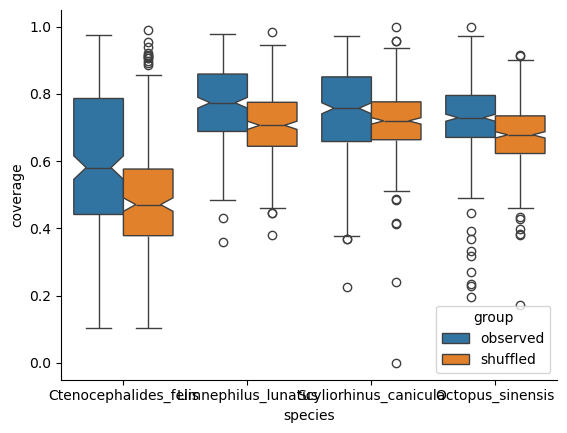

In [6]:
fig, ax = plt.subplots()
sns.boxplot(data=coverage_df.loc[coverage_df.teclass == 'all'], x='species', y='coverage', hue='group', notch=True)
# ax.set_yscale('log')
sns.despine()
plt.show()

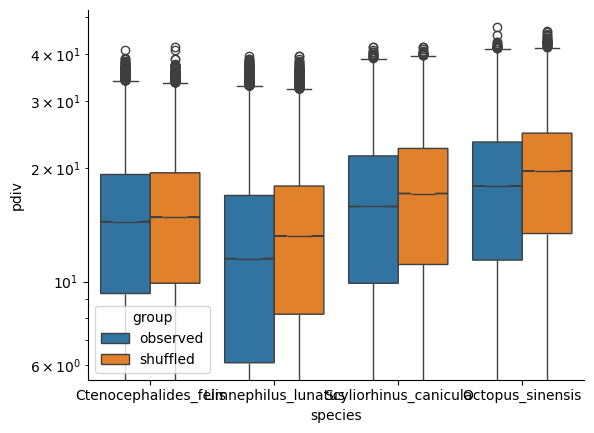

In [7]:
fig, ax = plt.subplots()
sns.boxplot(data=age_df, x='species', y='pdiv', hue='group', notch=True)
ax.set_yscale('log')
sns.despine()
plt.show()

In [8]:
age_df.head()

,zchrom,zstart,zend,chrom,start,end,tename,swscore,strand,pdiv,...,sleft,tetype,qstart,qend,qleft,repeat_id,species,group,tefam,teclass
0,QVAO01000059.1,3105,3253,QVAO01000059.1,3105,3253,DR002832680,920,-,7.9,...,(23128),Unspecified,(0),1020,879,4602,Ctenocephalides_felis,observed,Unspecified,Unspecified
1,QVAO01000059.1,3252,3897,QVAO01000059.1,3252,3897,DR002832529,4461,+,6.8,...,(22484),Unspecified,1257,1898,(0),4603,Ctenocephalides_felis,observed,Unspecified,Unspecified
2,QVAO01000059.1,3767,3913,QVAO01000059.1,3767,3913,DR002833259,748,+,13.2,...,(22468),Unspecified,4041,4186,(6052),4604,Ctenocephalides_felis,observed,Unspecified,Unspecified
3,QVAO01000059.1,3830,3944,QVAO01000059.1,3830,3944,DR002833259,261,+,20.3,...,(22437),Unspecified,3640,3748,(6490),4605,Ctenocephalides_felis,observed,Unspecified,Unspecified
4,QVAO01000059.1,5253,5578,QVAO01000059.1,5253,5578,DR002833548,1808,+,11.9,...,(20803),Unspecified,185,511,(702),4606,Ctenocephalides_felis,observed,Unspecified,Unspecified


In [12]:
# pcdh_bed = bt.BedTool('../data/beds/Octopus_sinensis_protocadherins.bed').sort()
te_bed = bt.BedTool('../data/repeatmasker-out/Octopus_sinensis/GCF_006345805.1_ASM634580v1_genomic.fna.bed')
teclass_dfs = te_bed_to_df('Octopus_sinensis', te_bed)
print(teclass_dfs['all'])
# te_bed = bt.BedTool.from_dataframe(teclass_dfs['all'])
# genomefile = '../data/genomes/GCF_006345805.1_ASM634580v1_genomic.genome'

# merged_slopped_pdch_bed = pcdh_bed \
#     .slop(g=genomefile,
#           b=1e5) \
#     .merge()
# merged_slopped_shuffled_pdch_bed = merged_slopped_pdch_bed \
#     .shuffle(g=genomefile)

# obs_df = merged_slopped_pdch_bed.coverage(b=te_bed).to_dataframe()
# exp_df = merged_slopped_shuffled_pdch_bed.coverage(b=te_bed).to_dataframe()
# obs_df['species'] = species
# exp_df['species'] = species
# obs_df['group'] = 'observed'
# exp_df['group'] = 'shuffled'
# obs_df['tefam'] = obs_df['tetype'].apply(lambda x: x.split('/')[-1])
# obs_df['teclass'] = obs_df['tetype'].apply(lambda x: x.split('/')[0])
# exp_df['tefam'] = exp_df['tetype'].apply(lambda x: x.split('/')[-1])
# exp_df['teclass'] = exp_df['tetype'].apply(lambda x: x.split('/')[0])

# pdch_df = pd.concat([obs_df, exp_df])

                   chrom  start    end            tename  swscore strand  \
0            NC_042997.1    463    646   ltr-1_family-63      682      +   
1            NC_042997.1    646    848   rnd-2_family-25     2087      -   
2            NC_042997.1   1082   1239   rnd-3_family-60      252      +   
3            NC_042997.1   1393   1535   ltr-1_family-99      470      -   
4            NC_042997.1   1411   1746  rnd-4_family-256     2799      -   
...                  ...    ...    ...               ...      ...    ...   
14260697  NW_021837044.1  66873  66920  rnd-6_family-330      212      -   
14260698  NW_021837044.1  66988  67012    rnd-1_family-1      387      -   
14260699  NW_021837044.1  67016  67087   ltr-1_family-99      389      -   
14260700  NW_021837044.1  67087  67155  rnd-6_family-789      271      -   
14260701  NW_021837044.1  67137  67356  rnd-1_family-190     1835      -   

          pdiv  pdel  pins        sleft             tetype  qstart  qend  \
0         1

In [19]:
pdch_df = pd.concat([obs_df, exp_df]).rename({'thickStart': 'coverage'}, axis=1)
pdch_df.shape

(98, 9)

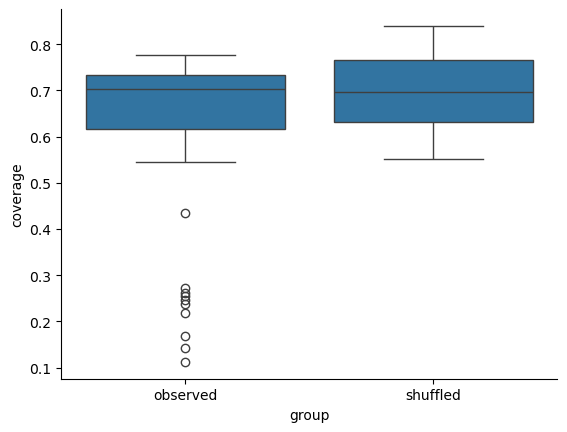

In [17]:
fig, ax = plt.subplots()
sns.boxplot(data=pdch_df, x='group', y='coverage', notch=False)
# ax.set_yscale('log')
sns.despine()
plt.show()

In [20]:
print(len(obs_df))

49
